In [9]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import h5py
import pickle
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from scipy.integrate import simps
from scipy.optimize import minimize
import emcee
import corner
from lal import C_SI
plt.rcParams.update({'font.size': 15})
matplotlib.rcParams['text.usetex'] = True

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [10]:
def dipole_cal(g, ra, dec, l=264, b=48):
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    phi = ra
    theta = np.pi/2-np.array(dec)

    nx = np.cos(phi)*np.sin(theta)
    ny = np.sin(phi)*np.sin(theta)
    nz = np.cos(theta)

    dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

    return dipole

In [11]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BBH/GW_injections_XG.p", "rb")
XG_BBH_inj = pickle.load(fr)
fr.close()

In [12]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/NSBH/GW_injections_XG.p", "rb")
XG_NSBH_inj = pickle.load(fr)
fr.close()

In [13]:
fr = open("/home/ansonchen/cosmic_dipole_gw/XG_golden/seed_1/BNS/GW_injections_XG.p", "rb")
XG_BNS_inj = pickle.load(fr)
fr.close()

In [14]:
dl_0_BBH = XG_BBH_inj['injections_parameters']['dls']
dl_0_NSBH = XG_NSBH_inj['injections_parameters']['dls']
dl_0_BNS = XG_BNS_inj['injections_parameters']['dls']

In [15]:
index_BBH = []
index_NSBH = []
index_BNS = []

for i in range(len(dl_0_BBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/BBH_cov_{i}.txt')
        if len(XG_BBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BBH[i]<461:
            index_BBH.append(i)
    except:
        continue

for i in range(len(dl_0_NSBH)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/NSBH_cov_{i}.txt')
        if len(XG_NSBH_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_NSBH[i]<461:
            index_NSBH.append(i)
    except:
        continue

for i in range(len(dl_0_BNS)):
    try:
        data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/BNS_cov_{i}.txt')
        if len(XG_BNS_inj['injections_parameters']['dets_pe'][i])>1 and 4*4*np.sqrt(data[4,4])*np.sqrt(data[5,5])*180*180/np.pi/np.pi<0.06 and dl_0_BNS[i]<461:
            index_BNS.append(i)
    except:
        continue


In [16]:
len(index_BBH),len(index_NSBH),len(index_BNS)

(33, 3, 3)

In [17]:
index_BBH

[1,
 2,
 3,
 7,
 8,
 9,
 14,
 15,
 16,
 17,
 18,
 21,
 22,
 24,
 27,
 28,
 29,
 30,
 32,
 33,
 36,
 37,
 39,
 42,
 43,
 44,
 46,
 48,
 50,
 51,
 53,
 54,
 57]

In [18]:
index_NSBH

[6, 23, 39]

In [19]:
index_BNS

[1, 40, 44]

In [20]:
# samples = [0]*(len(index_BBH)+len(index_NSBH)+len(index_BNS))
# for i,ind in enumerate(index_BBH):
#     samples[i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p001/BBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_NSBH):
#     samples[len(index_BBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p001/NSBH_Fisher_samples_{ind}.dat', names=True)
# for i,ind in enumerate(index_BNS):
#     samples[len(index_BBH)+len(index_NSBH)+i] = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/Fisher_sampler_XG_golden_seed_1_g0p001/BNS_Fisher_samples_{ind}.dat', names=True)


In [21]:
index_all = np.append(np.append(np.array(index_BBH),np.array(index_NSBH)),np.array(index_BNS))

In [22]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['ra']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['ra']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [23]:
# fig = plt.figure(figsize=(26,25))
# gs = gridspec.GridSpec(10, 8, wspace=0.1)

# for i in range(0,10):
#     for j in range(0,8):

#         if 8*i+j >= len(index_BBH)+len(index_NSBH)+len(index_BNS):
#             break

#         ax = plt.subplot(gs[8*i+j])
#         plt.title('event %d'%index_all[8*i+j])

#         plt.hist(samples[8*i+j]['dec']/np.pi*180,bins=50,histtype='step')

#         plt.axvline(np.mean(samples[8*i+j]['dec']/np.pi*180),color='k',linestyle='--',alpha=0.6)

#         if j==0:
#             ax.set_ylabel('likelihood',fontsize=15)

#         ax.set_yticklabels([])
#         # plt.xlim(10,200)
#         plt.ylim(bottom=0)

In [24]:
# ra_std = [0]*len(index_all)
# dec_std = [0]*len(index_all)
# ra_mean = [0]*len(index_all)
# dec_mean = [0]*len(index_all)
# for i in range(len(index_all)):
#     ra_std[i] = np.std(samples[i]['ra'])
#     dec_std[i] = np.std(samples[i]['dec'])
#     ra_mean[i] = np.mean(samples[i]['ra'])
#     dec_mean[i] = np.mean(samples[i]['dec'])

In [25]:
zs = [0]*len(index_all)
ra_mean = [0]*len(index_all)
dec_mean = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    zs[i] = XG_BBH_inj['injections_parameters']['zs'][ind]
    ra_mean[i] = XG_BBH_inj['injections_parameters']['ras'][ind]
    dec_mean[i] = XG_BBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_NSBH):
    zs[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+i] = XG_NSBH_inj['injections_parameters']['decs'][ind]
for i,ind in enumerate(index_BNS):
    zs[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['zs'][ind]
    ra_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['ras'][ind]
    dec_mean[len(index_BBH)+len(index_NSBH)+i] = XG_BNS_inj['injections_parameters']['decs'][ind]

In [26]:
g=0.001

z0 = [0]*len(index_all)
for i,ind in enumerate(index_BBH):
    z0[i] = (1+zs[i]) * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_NSBH):
    z0[len(index_BBH)+i] = (1+zs[len(index_BBH)+i]) * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind])) -1
for i,ind in enumerate(index_BNS):
    z0[len(index_BBH)+len(index_NSBH)+i] = (1+zs[len(index_BBH)+len(index_NSBH)+i]) * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) -1


In [27]:
ra_std = [0]*len(index_all)
dec_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/BBH_cov_{ind}.txt')
    ra_std[i] = np.sqrt(data[4,4])
    dec_std[i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_NSBH):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/NSBH_cov_{ind}.txt')
    ra_std[len(index_BBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+i] = np.sqrt(data[5,5])
for i,ind in enumerate(index_BNS):
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/BNS_cov_{ind}.txt')
    ra_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[4,4])
    dec_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[5,5])    

In [28]:
np.array(ra_std)/np.pi*180

array([0.04299412, 0.02024983, 0.09809105, 0.01269209, 0.02243056,
       0.03516993, 0.01941611, 0.02036643, 0.0287417 , 0.03032569,
       0.01924512, 0.0341696 , 0.04340001, 0.04975455, 0.04772199,
       0.09902578, 0.03155594, 0.06634135, 0.01868722, 0.01820875,
       0.01221388, 0.01613459, 0.03378354, 0.01430652, 0.03270819,
       0.07704266, 0.02244649, 0.05027913, 0.00476158, 0.04042543,
       0.0388847 , 0.02599123, 0.06361256, 0.03826926, 0.05340654,
       0.06899596, 0.07067683, 0.01927468, 0.08483649])

In [29]:
np.array(dec_std)/np.pi*180

array([0.00735631, 0.1587848 , 0.03326312, 0.04361225, 0.02045146,
       0.01190109, 0.02526227, 0.01450256, 0.0281104 , 0.00641455,
       0.01995567, 0.05563491, 0.07620158, 0.04161072, 0.04973931,
       0.01890997, 0.0225423 , 0.01902993, 0.0186926 , 0.04048752,
       0.15751543, 0.02967379, 0.03424354, 0.01966533, 0.03109025,
       0.01751234, 0.01180505, 0.05854938, 0.003732  , 0.01145596,
       0.02675105, 0.00686927, 0.01426093, 0.04661062, 0.04082235,
       0.04209555, 0.05059226, 0.09891896, 0.03487673])

In [30]:
np.array(ra_std)/np.pi*180*np.array(dec_std)/np.pi*180

array([3.16278045e-04, 3.21536539e-03, 3.26281489e-03, 5.53530440e-04,
       4.58737800e-04, 4.18560539e-04, 4.90495052e-04, 2.95365450e-04,
       8.07940799e-04, 1.94525718e-04, 3.84049158e-04, 1.90102227e-03,
       3.30714890e-03, 2.07032262e-03, 2.37365888e-03, 1.87257444e-03,
       7.11343599e-04, 1.26247132e-03, 3.49312596e-04, 7.37227252e-04,
       1.92387424e-03, 4.78774479e-04, 1.15686806e-03, 2.81342433e-04,
       1.01690560e-03, 1.34919733e-03, 2.64981933e-04, 2.94381154e-03,
       1.77702366e-05, 4.63112047e-04, 1.04020651e-03, 1.78540678e-04,
       9.07174216e-04, 1.78375399e-03, 2.18018081e-03, 2.90442270e-03,
       3.57570038e-03, 1.90663084e-03, 2.95881934e-03])

In [31]:
dl_mean = [0]*len(index_all)
dl_std = [0]*len(index_all)

for i,ind in enumerate(index_BBH):
    dl_mean[i] = dl_0_BBH[ind] * (1+dipole_cal(g, XG_BBH_inj['injections_parameters']['ras'][ind], XG_BBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/BBH_cov_{ind}.txt')
    dl_std[i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_NSBH):
    dl_mean[len(index_BBH)+i] = dl_0_NSBH[ind] * (1+dipole_cal(g, XG_NSBH_inj['injections_parameters']['ras'][ind], XG_NSBH_inj['injections_parameters']['decs'][ind]))
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/NSBH_cov_{ind}.txt')
    dl_std[len(index_BBH)+i] = np.sqrt(data[2,2])
for i,ind in enumerate(index_BNS):
    dl_mean[len(index_BBH)+len(index_NSBH)+i] = dl_0_BNS[ind] * (1+dipole_cal(g, XG_BNS_inj['injections_parameters']['ras'][ind], XG_BNS_inj['injections_parameters']['decs'][ind])) 
    data = np.genfromtxt(f'/home/ansonchen/cosmic_dipole_gw/code/covariance_XG_golden_seed_1_g0p001/BNS_cov_{ind}.txt')
    dl_std[len(index_BBH)+len(index_NSBH)+i] = np.sqrt(data[2,2])
 
    # dl_mean[i] = np.mean(samples[i]['luminosity_distance'])
    # dl_std[i] = np.std(samples[i]['luminosity_distance'])

In [32]:
def chi2_dl_dipole(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]
    
    dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
    dipole_ICRS = dipole_gal.transform_to('icrs')

    phi_dipole = dipole_ICRS.ra.value*np.pi/180
    theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

    nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
    ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
    nz_dipole = np.cos(theta_dipole)

    chi2 = 0

    for i in range(len(ra_arr)):
        phi = ra_arr[i]
        theta = np.pi/2-np.array(dec_arr[i])

        nx = np.cos(phi)*np.sin(theta)
        ny = np.sin(phi)*np.sin(theta)
        nz = np.cos(theta)

        dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

        astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
        zt = (1+zs_arr[i])/(1+dipole) -1
        dl_0 = astropy_cosmology.luminosity_distance(zt).value
        dl_g = dl_0*(1+dipole)

        chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2

    return chi2


In [33]:
chi2_dl_dipole([1.250e-04, 268, 48], ra_mean, dec_mean, z0, dl_mean, dl_std, H0=70, Om0=0.3)

524.9570529723661

In [34]:
minimize(chi2_dl_dipole, [0,268,48], args=(ra_mean, dec_mean, z0, dl_mean, dl_std), method='Nelder-Mead')

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1.4153952647406376e-10
             x: [ 1.000e-03  2.640e+02  4.800e+01]
           nit: 93
          nfev: 168
 final_simplex: (array([[ 1.000e-03,  2.640e+02,  4.800e+01],
                       [ 1.000e-03,  2.640e+02,  4.800e+01],
                       [ 1.000e-03,  2.640e+02,  4.800e+01],
                       [ 1.000e-03,  2.640e+02,  4.800e+01]]), array([ 1.415e-10,  3.497e-10,  5.510e-10,  8.261e-10]))

In [35]:
# cov_index = [0]*len(index)
# for i,ind in enumerate(index):
#     cov_data = np.loadtxt(f'covariance_XG_snr500/cov_{ind}.txt')
#     cov_index[i] = np.zeros((3,3))
#     cov_index[i][0,0] = cov_data[2,2]
#     cov_index[i][0,1:] = cov_data[2,4:]
#     cov_index[i][1:,0] = cov_data[4:,2]
#     cov_index[i][1:,1:] = cov_data[4:,4:]

In [56]:
def logprob_dl_g(glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, H0=70, Om0=0.3):
    g = glb[0]
    l = glb[1]
    b = glb[2]

    if 0<=g<1 and 0<=l<360 and -90<=b<=90:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            # x = np.array([dl_g, ra_arr[i], dec_arr[i]])
            # mu = np.array([dl_mean[i], ra_arr[i], dec_arr[i]])
            # diff = x - mu
            
            # chi2 += np.dot(diff, np.linalg.solve(cov_matrix, diff))
            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob


In [57]:
nwalkers = 32
ndim = 3
p0 = np.random.rand(nwalkers, ndim)*np.array([1,360,180]) - np.array([0,0,90])
print(p0)

[[ 9.90163357e-01  3.04275764e+02 -8.40744838e+01]
 [ 5.04339157e-01  2.53047469e+02 -5.71873932e+01]
 [ 4.78277778e-01  2.91577090e+02 -7.14386828e+01]
 [ 1.78381420e-01  1.26653890e+02 -2.84720556e+00]
 [ 4.29549568e-02  1.10848011e+02  7.77465157e+01]
 [ 4.77130654e-01  4.91285640e+01 -4.23192654e+01]
 [ 2.21194508e-01  1.08267442e+02 -8.09144541e+01]
 [ 5.89708018e-01  1.18713064e+02  8.42097501e+01]
 [ 9.61321263e-01  8.58531789e+00 -8.45170785e+01]
 [ 3.03214573e-01  2.44339044e+02  4.92488090e+01]
 [ 8.24241571e-01  3.34587981e+02  4.90298051e+01]
 [ 5.97629413e-02  2.04796676e+02  5.54870598e+01]
 [ 7.48563965e-01  2.69701014e+02 -5.72792523e+01]
 [ 8.27177109e-01  2.03865867e+02  1.66167082e+01]
 [ 6.33405063e-01  2.92473138e+02 -3.12972454e+01]
 [ 1.56191778e-01  1.46342390e+02  8.47058558e+01]
 [ 1.50794146e-01  6.95305104e+01  8.75582500e+01]
 [ 2.16964543e-01  3.04162372e+02  7.08270429e+01]
 [ 4.59829303e-01  9.46632732e+01 -3.97209296e+01]
 [ 6.36431950e-01  1.12041671e+

In [58]:
logprob_dl_g(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-317554216.17756194

In [59]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [60]:
state = sampler.run_mcmc(p0, 100)
# sampler.reset()

(array([1.848e+03, 2.000e+02, 1.810e+02, 1.060e+02, 7.500e+01, 4.500e+01,
        2.600e+01, 2.000e+01, 6.900e+01, 2.100e+01, 2.200e+01, 6.000e+00,
        1.700e+01, 1.500e+01, 1.000e+01, 5.000e+01, 2.000e+00, 7.000e+00,
        4.200e+01, 1.500e+01, 6.000e+00, 6.000e+00, 2.500e+01, 4.000e+00,
        3.000e+00, 1.700e+01, 1.200e+01, 1.000e+01, 4.000e+00, 1.000e+01,
        3.000e+00, 7.000e+00, 1.000e+00, 1.700e+01, 1.000e+01, 0.000e+00,
        1.400e+01, 9.000e+00, 5.000e+00, 9.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 5.000e+00, 3.000e+00, 1.100e+01, 1.000e+00, 1.000e+00,
        7.000e+00, 1.000e+00, 1.300e+01, 9.000e+00, 4.000e+00, 2.000e+00,
        3.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 5.000e+00, 3.000e+00,
        2.000e+00, 1.200e+01, 3.000e+00, 1.000e+00, 5.000e+00, 0.000e+00,
        0.000e+00, 6.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 1.500e+01, 6.000e+00,
        8.000e+00, 1.400e+01, 0.000e+0

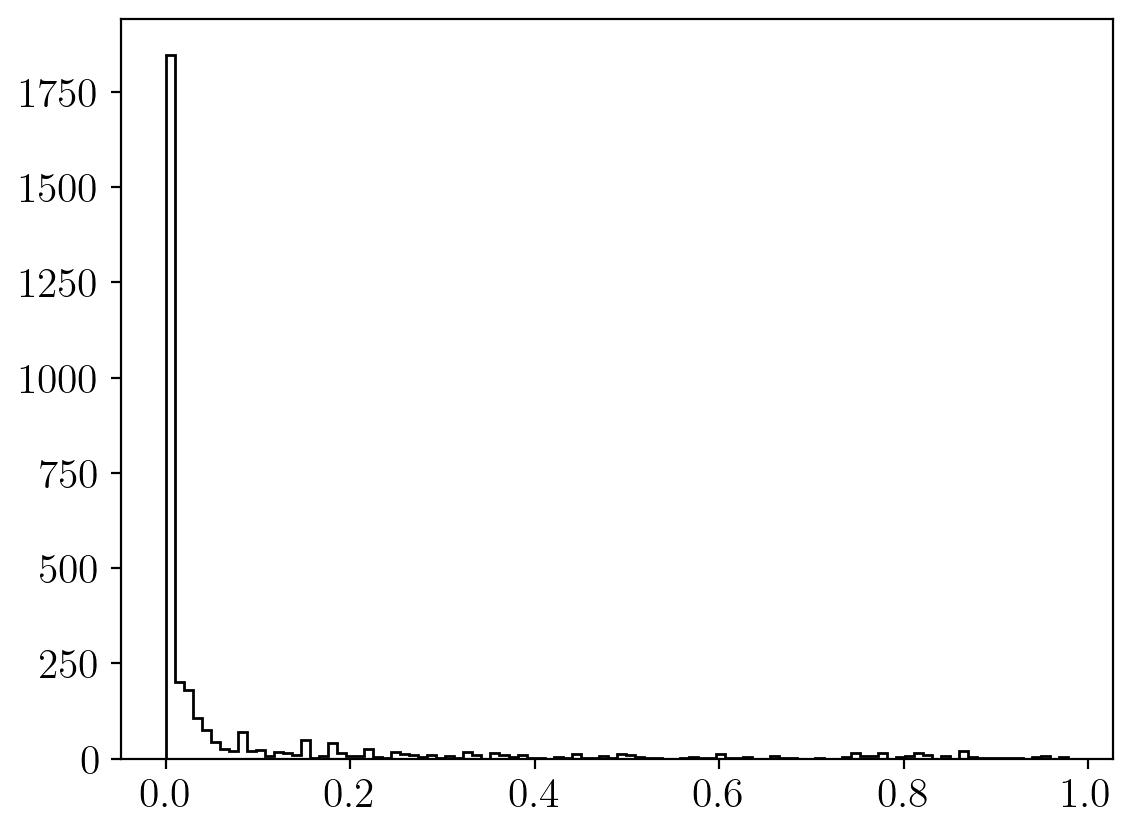

In [61]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

(array([24., 19., 79., 35., 22., 55., 25., 88., 32., 37., 16., 12., 53.,
        57.,  5., 32., 30., 14., 34., 23., 15., 20., 28., 23.,  5., 36.,
        73., 24., 39.,  5., 38., 44., 33., 25., 29., 33., 61., 59., 39.,
        44., 47., 41., 58., 49., 55., 15., 77., 30., 60., 50., 54., 47.,
        43., 29., 41., 34., 25., 29., 16.,  9., 27., 20., 49., 38., 24.,
        30., 64., 30., 51., 23., 32., 38., 55., 43., 39., 26., 53., 42.,
        64., 47., 28., 45., 54.,  8., 29., 13., 11.,  1., 10.,  0.,  0.,
        19.,  0.,  0.,  0.,  2.,  5.,  0.,  0.,  6.]),
 array([  0.7260022 ,   4.2318767 ,   7.7377512 ,  11.24362571,
         14.74950021,  18.25537471,  21.76124922,  25.26712372,
         28.77299822,  32.27887272,  35.78474723,  39.29062173,
         42.79649623,  46.30237074,  49.80824524,  53.31411974,
         56.81999424,  60.32586875,  63.83174325,  67.33761775,
         70.84349226,  74.34936676,  77.85524126,  81.36111576,
         84.86699027,  88.37286477,  91.87873927, 

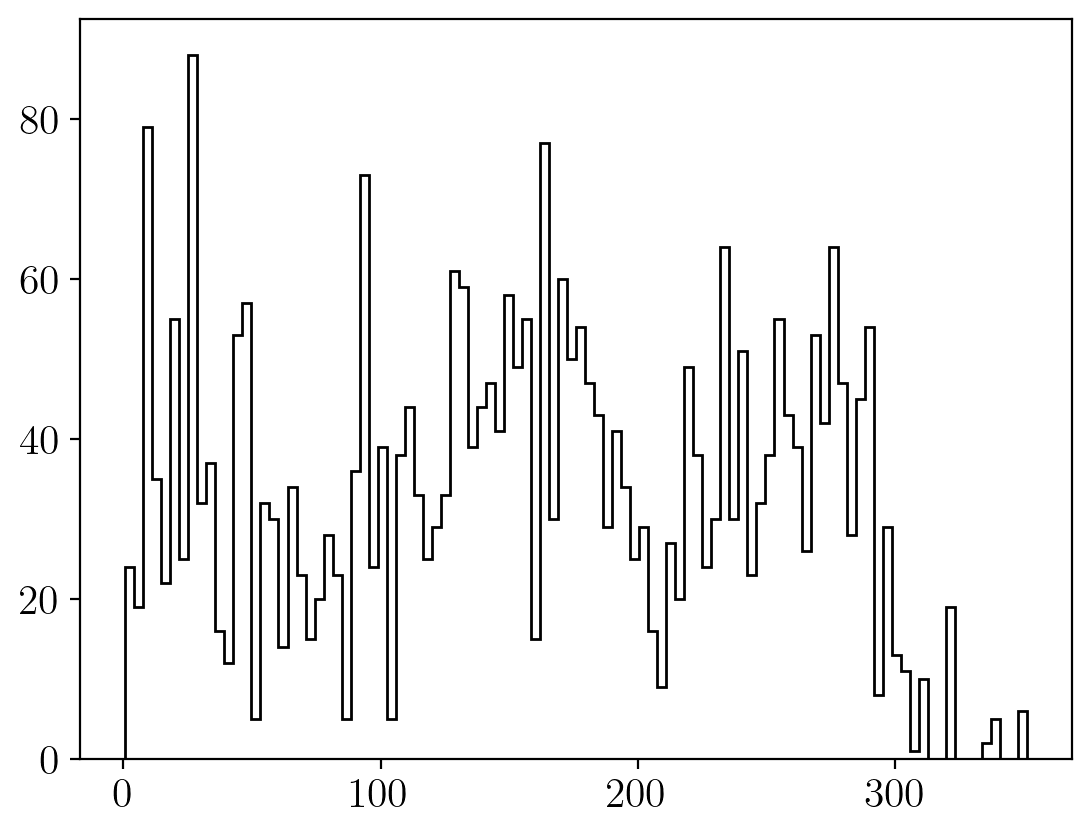

In [62]:
plt.hist(samples[:, 1], 100, color="k", histtype="step")

In [63]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[1.01222454e-03 2.63118843e+02 4.67379842e+01]
 [9.81222459e-04 2.63453725e+02 4.99628384e+01]
 [1.00960768e-03 2.68421273e+02 4.96277576e+01]
 [9.96170748e-04 2.66698285e+02 4.81093670e+01]
 [9.43602697e-04 2.66958464e+02 4.65623350e+01]
 [9.50064597e-04 2.63484076e+02 4.37116700e+01]
 [9.55885508e-04 2.61053243e+02 4.83234891e+01]
 [9.75460131e-04 2.56467951e+02 4.58314983e+01]
 [1.01239743e-03 2.68946466e+02 4.50776185e+01]
 [9.31830614e-04 2.62061358e+02 4.12559035e+01]
 [1.05436154e-03 2.62450517e+02 5.45604411e+01]
 [1.01111520e-03 2.65352709e+02 4.82443857e+01]
 [9.66645532e-04 2.63127728e+02 5.10588796e+01]
 [1.03234512e-03 2.62173807e+02 4.90806022e+01]
 [1.03827827e-03 2.59830511e+02 4.75154215e+01]
 [9.84260614e-04 2.63785577e+02 4.32104703e+01]
 [1.02867095e-03 2.65396678e+02 4.69082584e+01]
 [1.01249694e-03 2.66423372e+02 4.60005979e+01]
 [1.05024970e-03 2.65337796e+02 4.07888975e+01]
 [9.58241920e-04 2.67293480e+02 5.42612807e+01]
 [9.16367167e-04 2.64771877e+02 4.

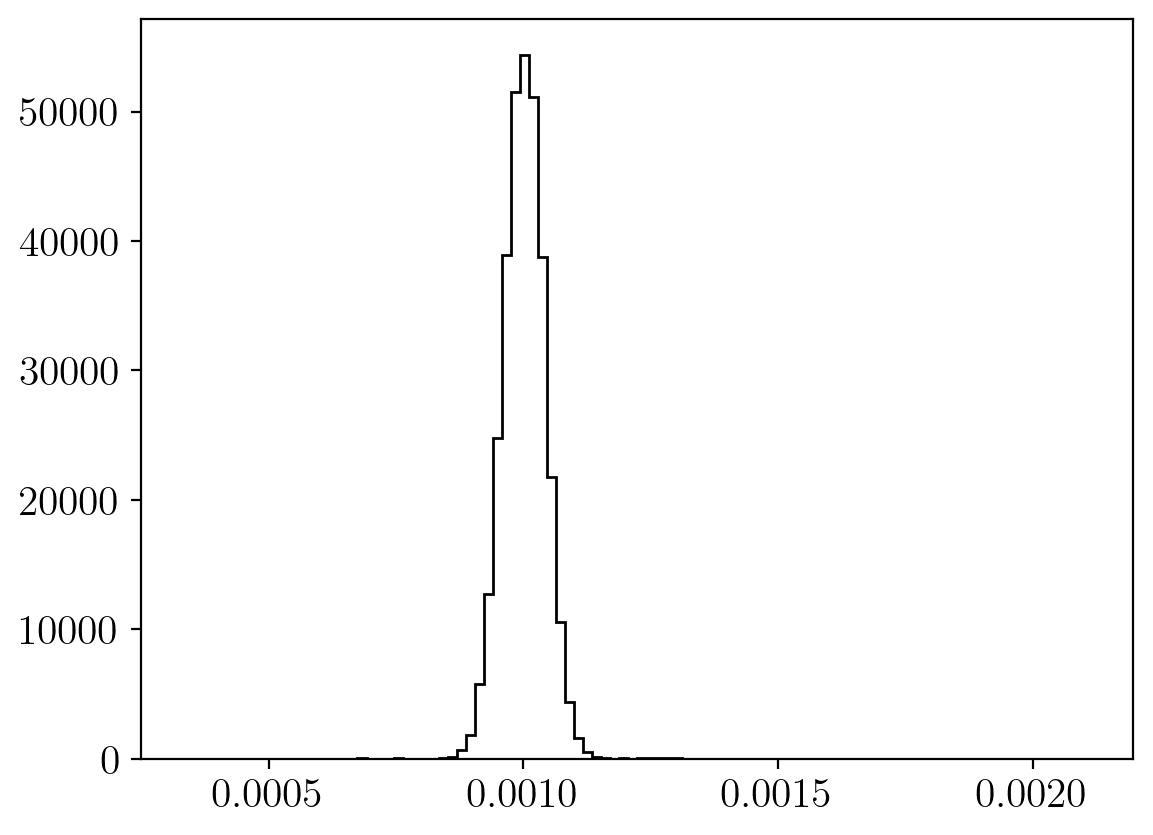

In [64]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")
plt.savefig('../plots/emcee_dip_g0p001.png',dpi=600)

In [65]:
np.savetxt('emcee_sample_dip_g0p001.txt',samples)

In [66]:
# samples = np.loadtxt('emcee_sample_dip_g0p001.txt')

In [67]:
samples[:,0]*=1e3

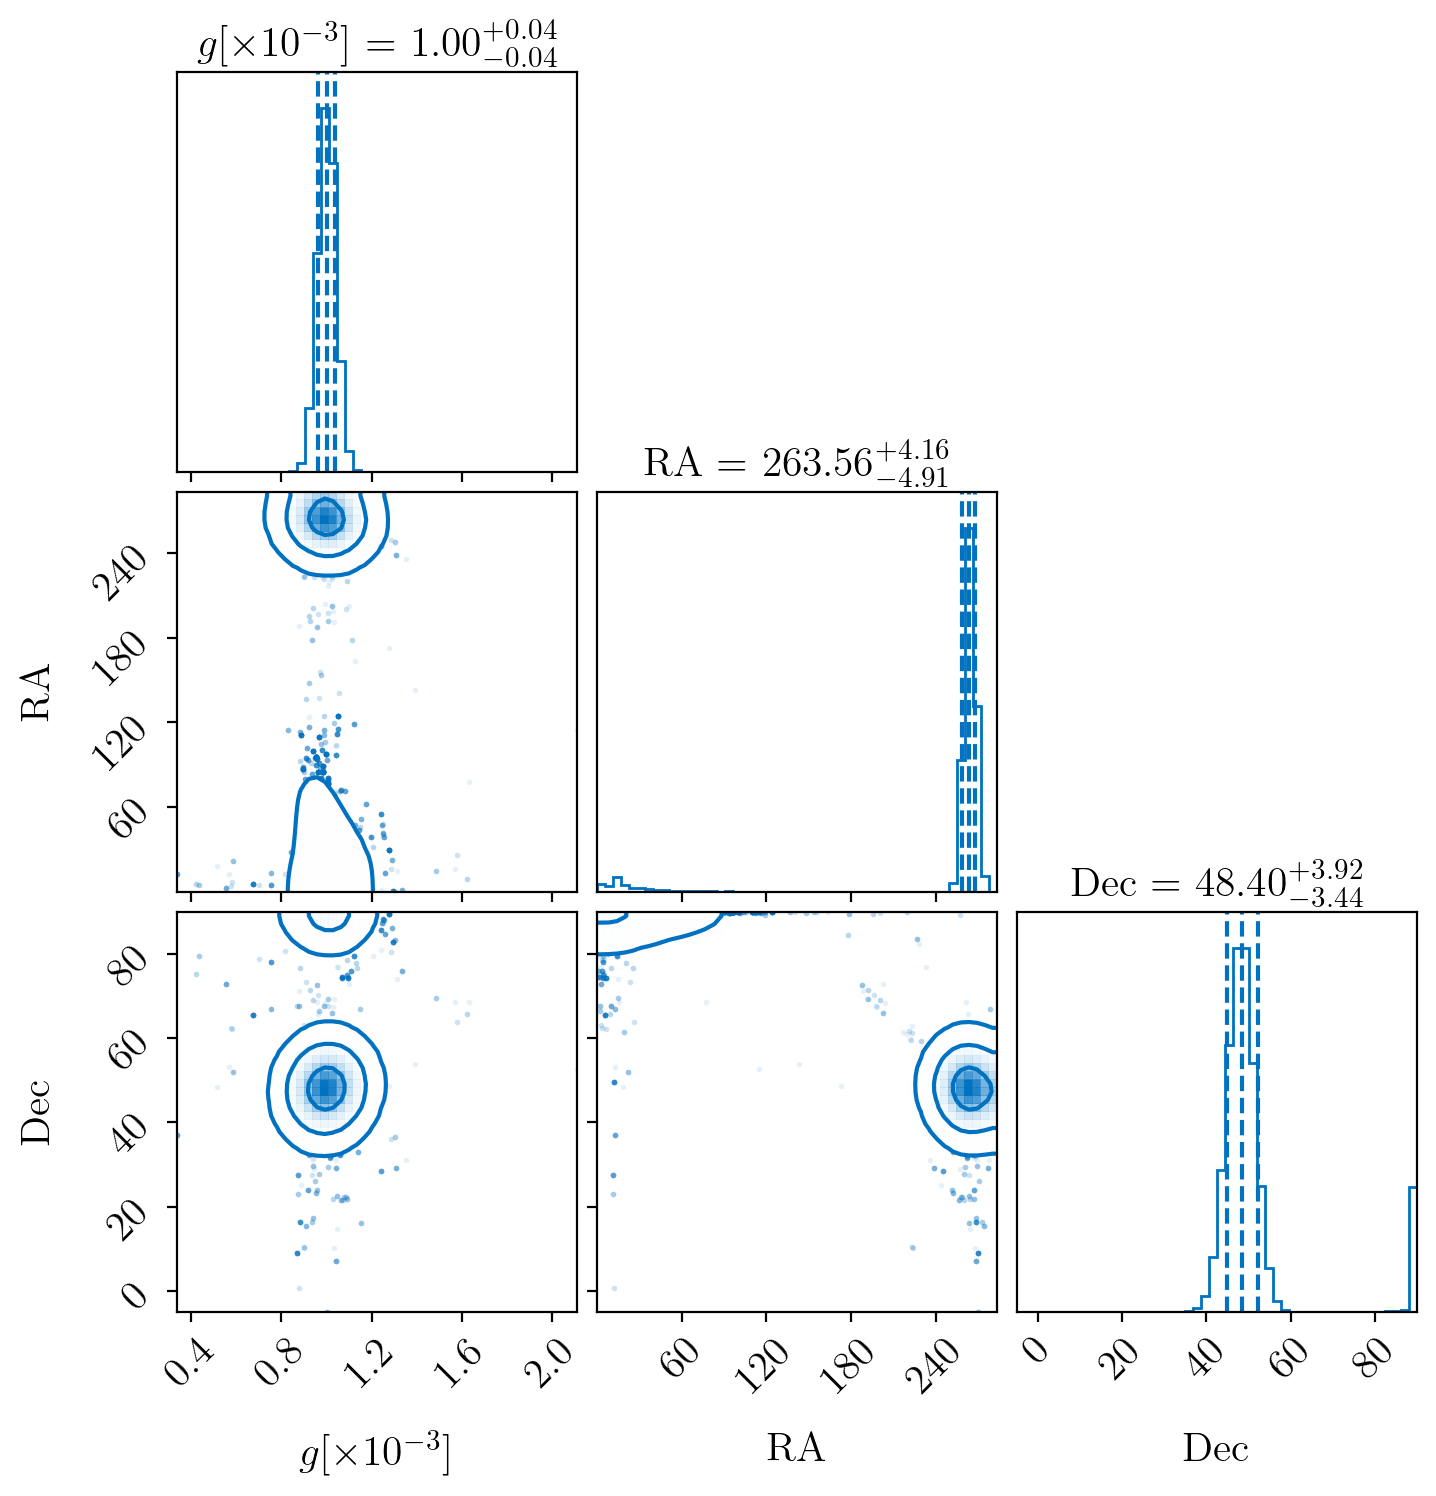

In [68]:
labels=[r'$g[\times 10^{-3}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p001_corner.pdf',bbox_inches='tight')

In [36]:
def logprob_dl_g_H0(H0glb, ra_arr, dec_arr, zs_arr, dl_mean, dl_std, Om0=0.3):
    H0 = H0glb[0]
    g = H0glb[1]
    l = H0glb[2]
    b = H0glb[3]

    if 0<=g<1 and 0<=l<360 and -90<=b<=90 and 10<H0<200:

        dipole_gal = SkyCoord(l*u.deg, b*u.deg, frame='galactic')
        dipole_ICRS = dipole_gal.transform_to('icrs')

        phi_dipole = dipole_ICRS.ra.value*np.pi/180
        theta_dipole = np.pi/2-dipole_ICRS.dec.value*np.pi/180

        nx_dipole = np.cos(phi_dipole)*np.sin(theta_dipole)
        ny_dipole = np.sin(phi_dipole)*np.sin(theta_dipole)
        nz_dipole = np.cos(theta_dipole)

        chi2 = 0

        for i in range(len(ra_arr)):
            phi = ra_arr[i]
            theta = np.pi/2-np.array(dec_arr[i])

            nx = np.cos(phi)*np.sin(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(theta)

            dipole = g*(nx_dipole*nx + ny_dipole*ny + nz_dipole*nz)

            astropy_cosmology = FlatLambdaCDM(Om0=Om0,H0=H0)
            zt = (1+zs_arr[i])/(1+dipole) -1
            dl_0 = astropy_cosmology.luminosity_distance(zt).value
            dl_g = dl_0*(1+dipole)

            chi2 += (dl_mean[i]-dl_g)**2 / dl_std[i]**2
        
        logprob = -0.5*chi2

    else:
        logprob = -np.inf

    return logprob

In [37]:
nwalkers = 32
ndim = 4
p0 = np.random.rand(nwalkers, ndim)*np.array([190,1,360,180]) - np.array([-10,0,0,90])
print(p0)

[[ 7.33516427e+01  2.19130624e-02  6.75774198e+01 -3.71035402e+01]
 [ 8.98883957e+01  4.83244664e-01  2.74480631e+02 -4.17382284e+01]
 [ 9.24158150e+01  1.28517904e-01  9.53543198e+01  5.01023450e+01]
 [ 2.21103044e+01  9.74576733e-01  1.56953032e+02 -6.35328919e+01]
 [ 2.96028051e+01  5.27671764e-01  1.93530575e+02  2.96069496e+01]
 [ 1.83990206e+02  5.08160361e-01  6.19459294e+01 -2.35717270e+00]
 [ 1.02933301e+02  2.42196351e-01  1.50620691e+02 -2.47955986e+01]
 [ 4.47255107e+01  2.77586671e-01  3.24651863e+02  9.42710903e+00]
 [ 3.29035357e+01  1.44351399e-01  3.67205874e+01  2.53672656e+01]
 [ 1.90380751e+01  5.58342791e-01  1.35557710e+02  8.41059793e+01]
 [ 1.80402746e+02  4.10899169e-01  1.85098203e+02 -2.99498968e+01]
 [ 2.29125426e+01  1.44318098e-01  1.92671361e+02 -4.46760657e+01]
 [ 1.49401846e+02  3.52636169e-01  1.07926177e+02 -8.17692260e+01]
 [ 1.74732848e+02  2.24307329e-01  1.47161095e+02  2.12648393e+01]
 [ 6.88088412e+01  7.34403132e-01  2.06712618e+02  1.71896885e

In [38]:
logprob_dl_g_H0(p0[0], ra_mean, dec_mean, z0, dl_mean, dl_std)

-136667.06407993825

In [39]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob_dl_g_H0, args=[ra_mean, dec_mean, z0, dl_mean, dl_std])


In [40]:
state = sampler.run_mcmc(p0, 100)


(array([  1.,   2.,   4.,   0.,   1.,   1.,   1.,   0.,   1.,   0.,   1.,
          0.,   5.,   0.,   9.,   2.,   8.,   0.,   4.,   6.,  11.,   4.,
          3.,  12.,   0.,   0.,  17.,  25., 186., 505., 208., 173.,  93.,
         60.,  58.,  98.,  80.,  75.,  79.,  75.,  73.,  80.,  62.,  65.,
         82.,  47.,  60.,  67.,  44.,  17.,  41.,  31.,  39.,  37.,  45.,
         38.,  47.,  42.,  33.,  29.,  17.,   5.,  17.,  24.,  35.,   4.,
          8.,  17.,  15.,  17.,  22.,  13.,   2.,  30.,   3.,  17.,   4.,
         16.,  15.,   6.,   6.,   9.,   6.,   5.,   8.,   0.,  18.,   6.,
          1.,   0.,  17.,   6.,   9.,   2.,  18.,   3.,   0.,   0.,   6.,
          6.]),
 array([ 19.0380751 ,  20.81486967,  22.59166424,  24.36845881,
         26.14525337,  27.92204794,  29.69884251,  31.47563708,
         33.25243164,  35.02922621,  36.80602078,  38.58281535,
         40.35960991,  42.13640448,  43.91319905,  45.68999362,
         47.46678819,  49.24358275,  51.02037732,  52.79717189

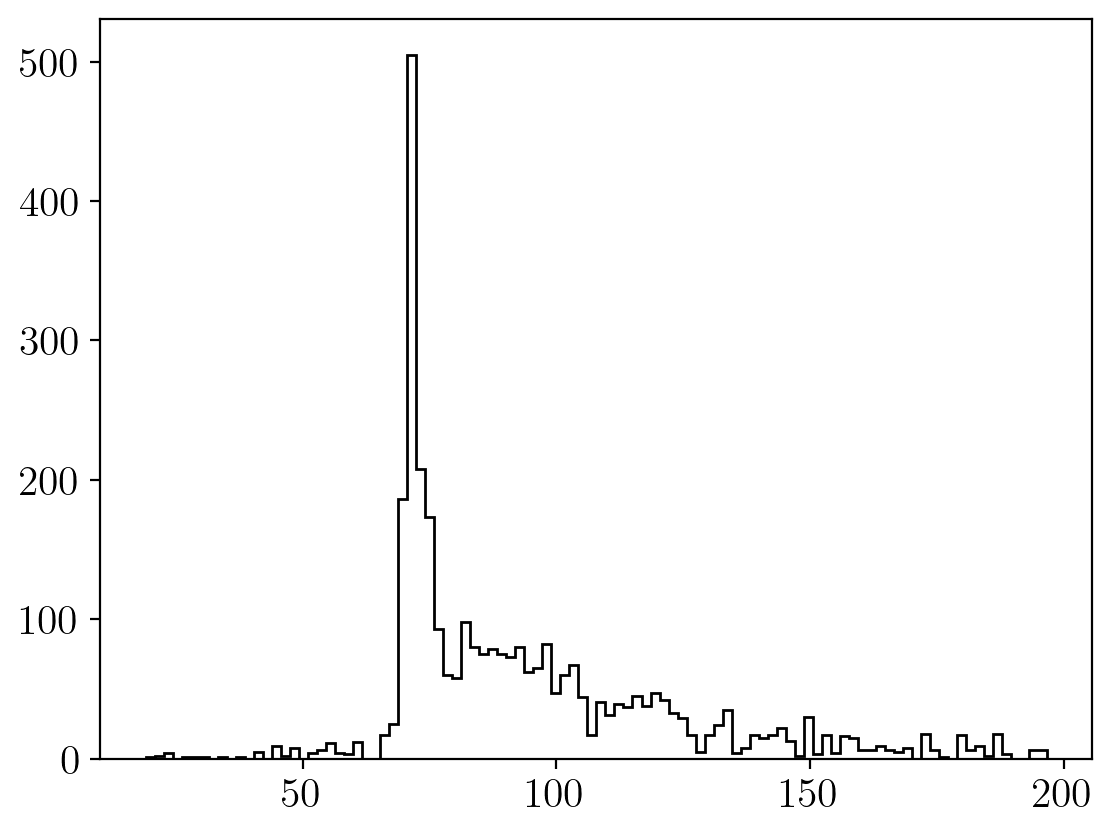

In [41]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 100, color="k", histtype="step")

In [42]:
sampler.reset()
sampler.run_mcmc(state, 10000)

State([[ 6.99549743e+01  9.78699481e-04  2.62004667e+02  4.65922502e+01]
 [ 7.00835854e+01  9.86200916e-04  2.62900368e+02  5.48781460e+01]
 [ 6.99546716e+01  1.00533203e-03  2.67051470e+02  4.38857718e+01]
 [ 7.00175071e+01  1.01271441e-03  2.65375026e+02  4.58467411e+01]
 [ 7.03087609e+01  8.87761433e-04  3.75562852e+00  8.93560152e+01]
 [ 7.00613393e+01  9.19188255e-04  2.62676425e+02  4.31506337e+01]
 [ 6.99553112e+01  1.01612295e-03  2.60484969e+02  4.51396688e+01]
 [ 6.99682577e+01  1.06898718e-03  2.55064855e+02  5.09114535e+01]
 [ 7.01443664e+01  9.85881707e-04  2.55511812e+02  5.99748233e+01]
 [ 7.04147779e+01  8.91356431e-04  5.88013417e+00  8.94775515e+01]
 [ 7.00573710e+01  1.01490239e-03  2.61157666e+02  4.98440443e+01]
 [ 6.99603932e+01  9.73245032e-04  2.66204619e+02  4.56684110e+01]
 [ 6.99902217e+01  9.69003659e-04  2.66696941e+02  5.03999329e+01]
 [ 7.00346399e+01  9.91998034e-04  2.57178949e+02  5.16269141e+01]
 [ 7.00182255e+01  9.91062347e-04  2.62733958e+02  4.923

Text(0, 0.5, 'Count')

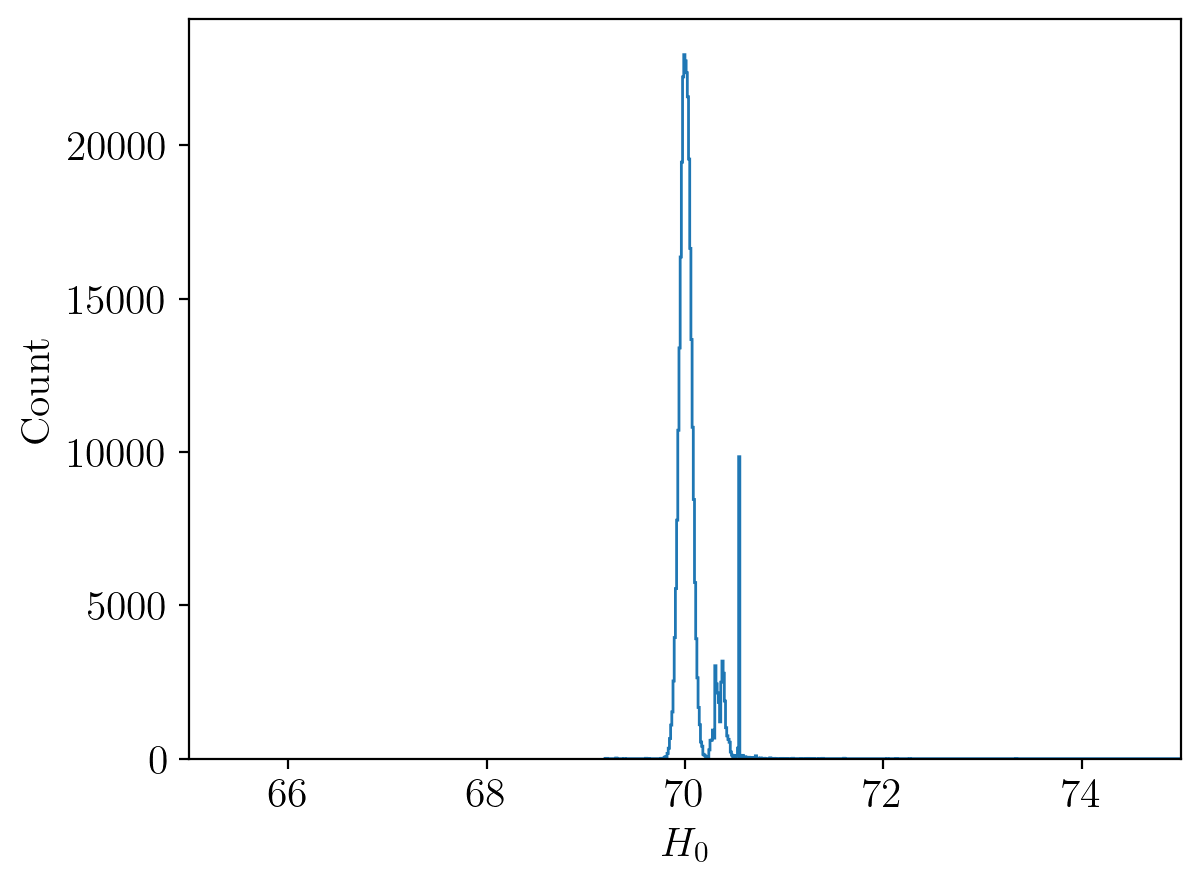

In [43]:
samples = sampler.get_chain(flat=True)
plt.hist(samples[:, 0], 1000, histtype="step")
plt.xlim(65,75)
plt.xlabel(r'$H_0$')
plt.ylabel('Count')

In [44]:
np.savetxt('emcee_sample_dip_g0p001_H0.txt',samples)

In [45]:
samples[:,1]*=1e3

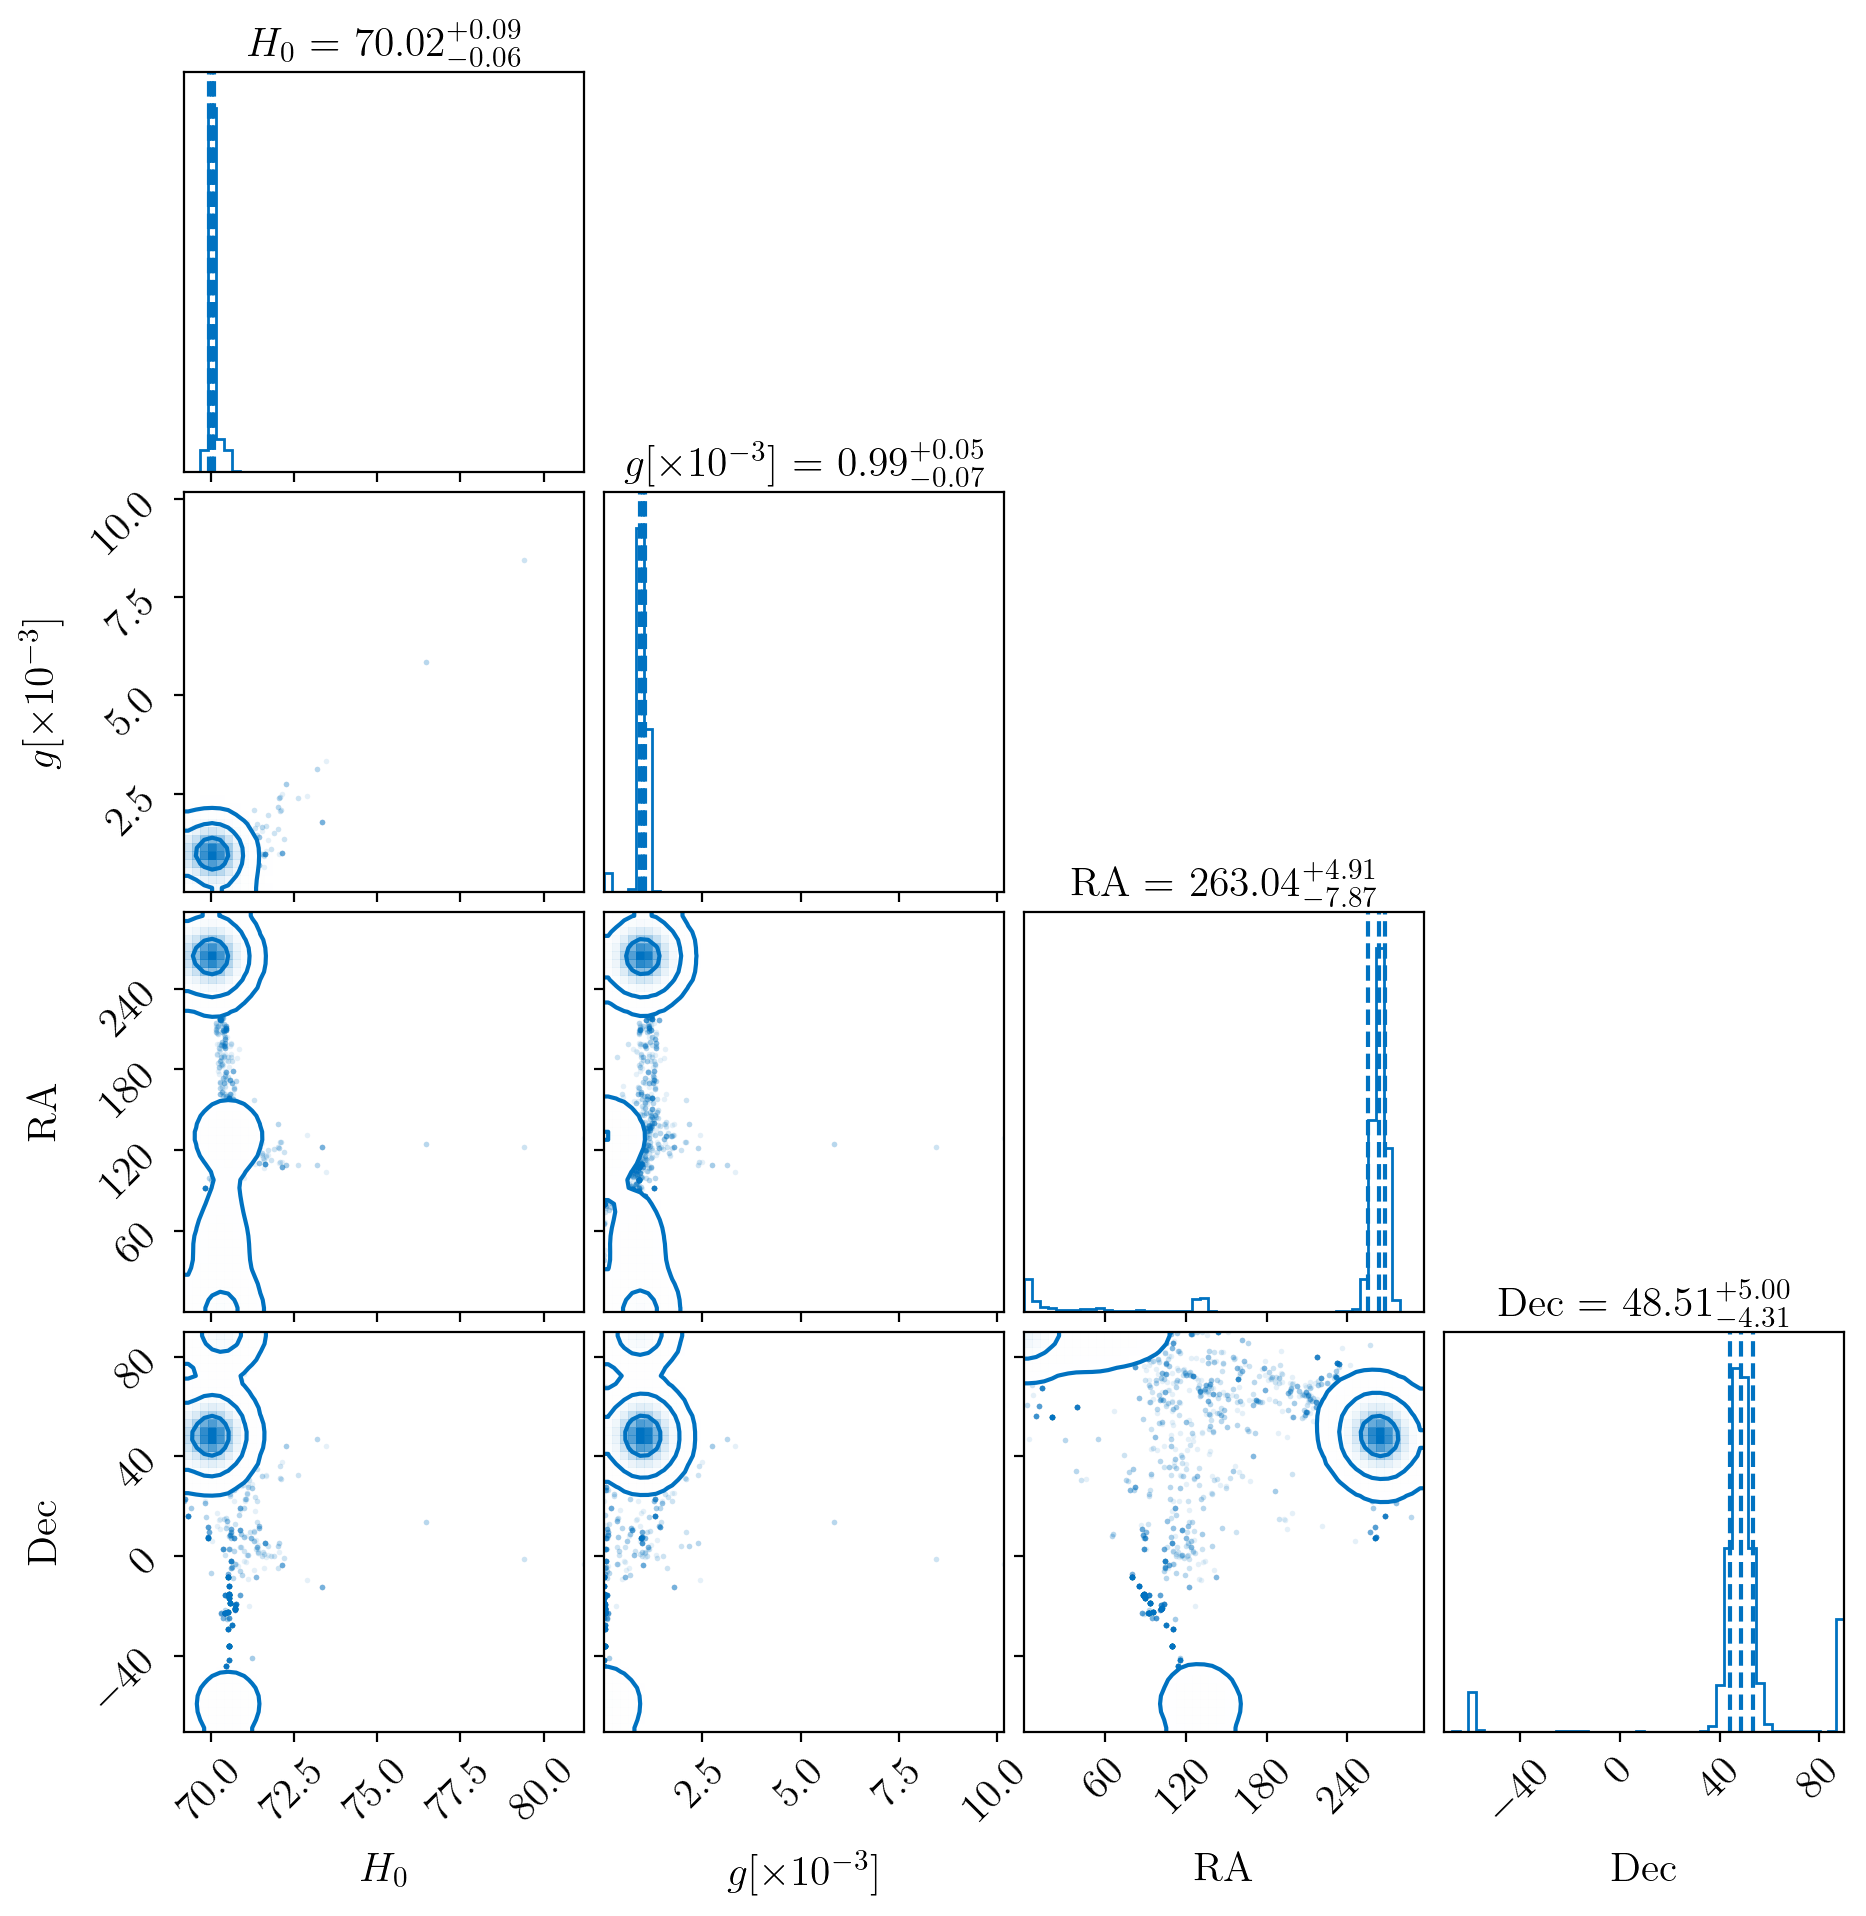

In [46]:
labels=[r'$H_0$',r'$g[\times 10^{-3}]$', 'RA', 'Dec']

fig = corner.corner(samples,quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p001_H0_corner.pdf',bbox_inches='tight')

In [47]:
samples = np.loadtxt('emcee_sample_dip_g0p001_H0.txt')

In [48]:
samples[:,1]*=1e3

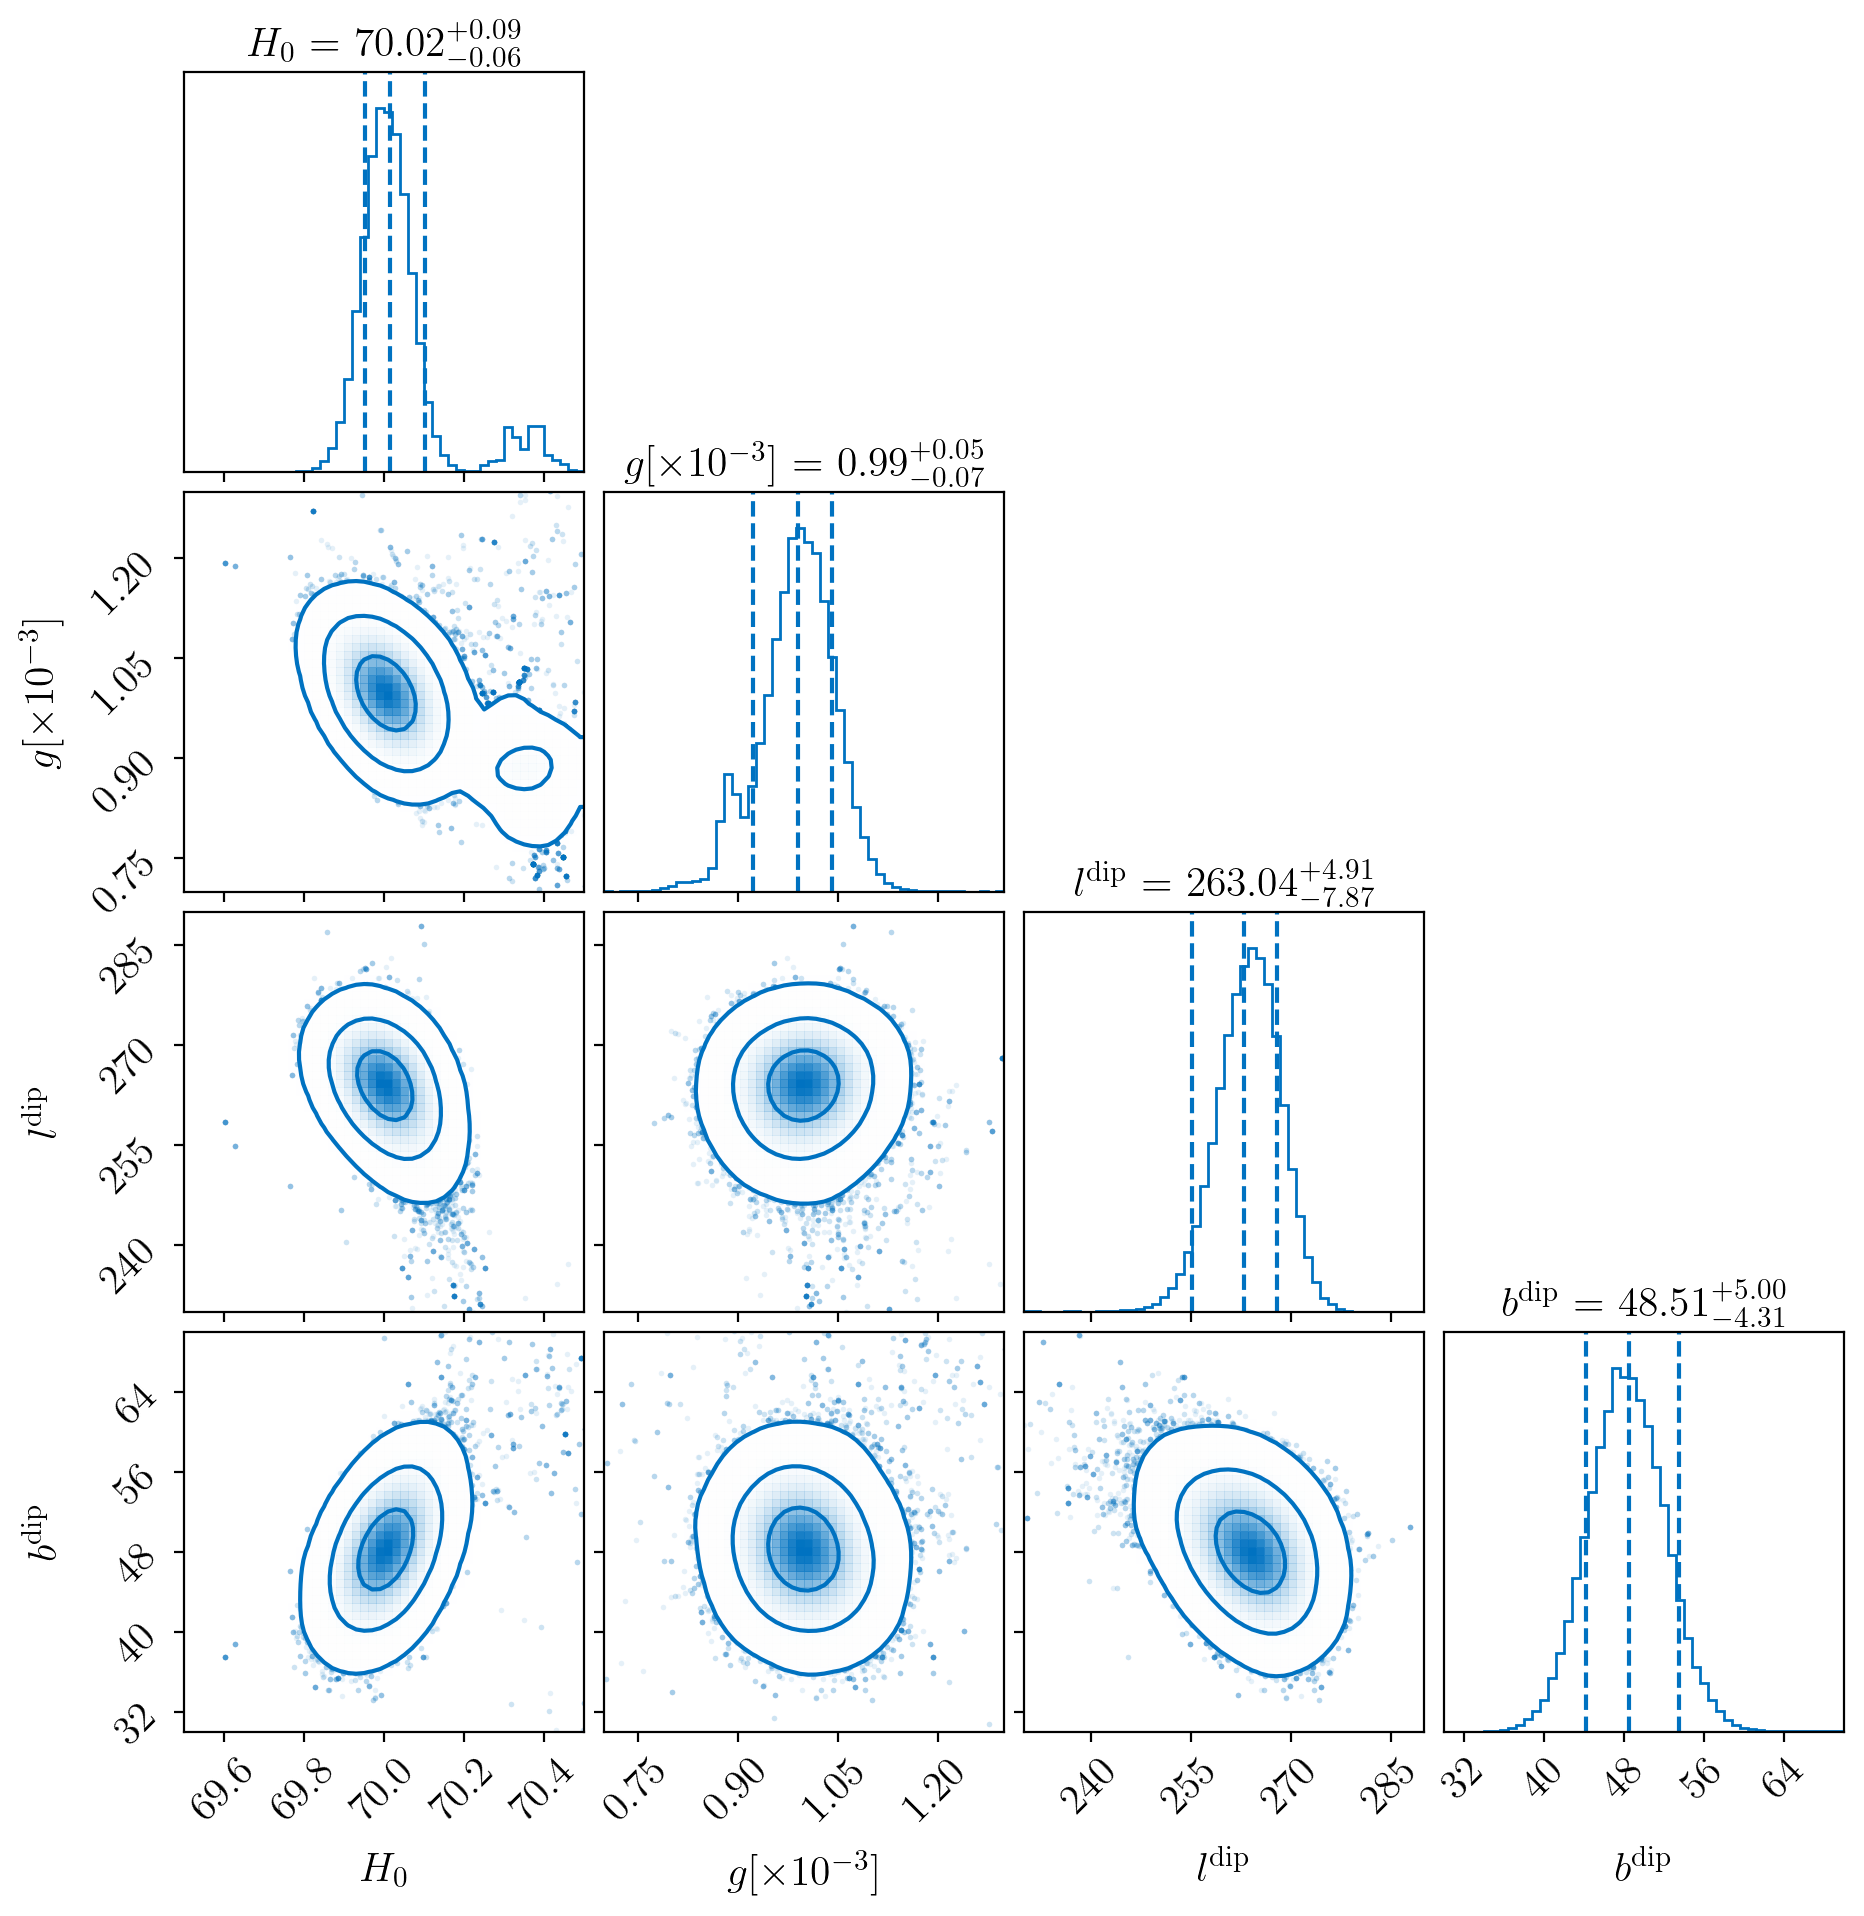

In [50]:
labels=[r'$H_0$',r'$g[\times 10^{-3}]$', r'$l^{\rm dip}$', r'$b^{\rm dip}$']

# fig = corner.corner(np.array(samples), range=[(69.75,70.25),(0.7,1.3),(220,300),(25,75)], quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
fig = corner.corner(np.array(samples), range=[(69.5,70.5),(0.7,1.3),(230,290),(30,70)], quantiles=[0.16, 0.5, 0.84], show_titles=True, bins=50, smooth=2, label_kwargs=dict(fontsize=15), color='#0072C1', levels=(1-np.exp(-0.5),1-np.exp(-2),1-np.exp(-4.5)), title_kwargs={"fontsize": 15},labels=labels)
plt.savefig('../plots/emcee_dip_g0p001_H0_corner_zoom.pdf',bbox_inches='tight')

In [53]:
Omega_m=0.3
Omega_Lambda=0.7

integrand = lambda zz: 1./np.sqrt(Omega_m*(1+zz)**3 + Omega_Lambda)

dlH0overc = []
for i in range(len(index_all)):
    zarr = np.linspace(0,z0[i],1000)
    dlH0overc.append((1+z0[i])*simps(integrand(zarr), zarr))

H0 = np.array(dlH0overc)* C_SI*1e-3 / np.array(dl_mean)


/tmp/ipykernel_46990/1784687697.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  dlH0overc.append((1+z0[i])*simps(integrand(zarr), zarr))


In [54]:
import astropy.coordinates as coord
import matplotlib as mpl
plt.rcParams.update({'font.size': 15})
mpl.rcParams['text.usetex'] = True

%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def coordinates_aitoff_plot(coords,H0):
    fig, ax = plt.subplots(figsize=(10, 4), 
                           subplot_kw=dict(projection="aitoff"))
    # fig.subplots_adjust(bottom=0.2)

    sph = coords.spherical
    cs = ax.scatter(-sph.lon.wrap_at(180*u.deg).radian,
                    sph.lat.radian,marker='.',s=100,
                    c=H0,cmap='coolwarm')

    def fmt_func_x(x, pos):
        val = coord.Angle(-x*u.radian).wrap_at(360*u.deg).degree
        return f'${val:.0f}' + r'^{\circ}$'

    xticker = mpl.ticker.FuncFormatter(fmt_func_x)
    ax.xaxis.set_major_formatter(xticker)
    ax.xaxis.set_ticks([-np.pi*2/3,-np.pi/3,0,np.pi/3,np.pi*2/3])
    # ax.yaxis.set_ticks([-np.pi/3,-np.pi/6,0,np.pi/3,np.pi/6])

    ax.grid()
    
    cb = fig.colorbar(cs)
    cb.set_label(r'$H_0~[{\rm km}~{\rm s}^{-1}~{\rm Mpc}^{-1}]$')
    cb.set_ticks([min(H0),70,max(H0)])
    # plt.clim(-0.01,0.01)
    
    return fig, ax

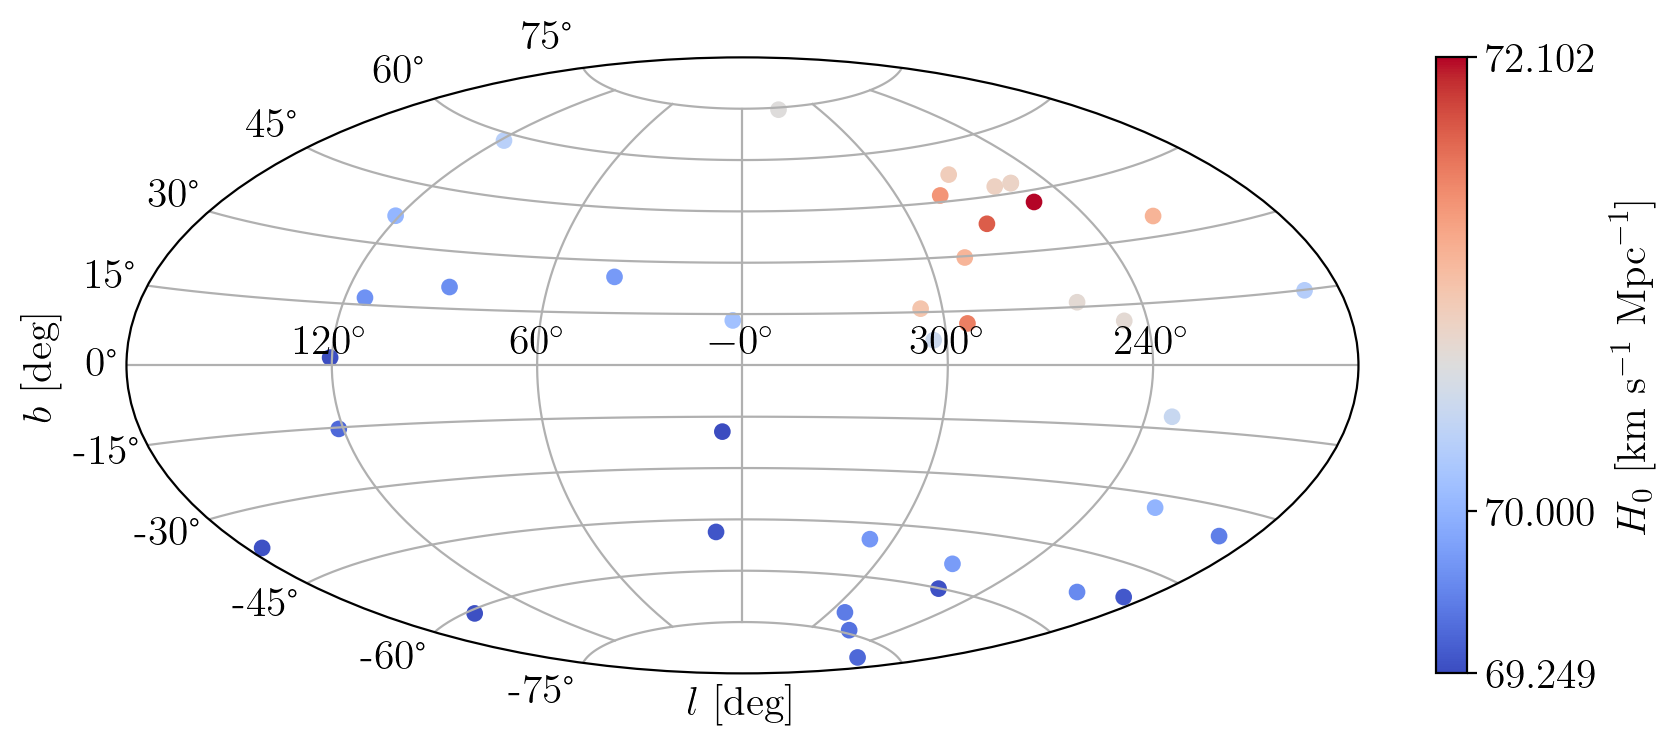

In [55]:
coord_golden = SkyCoord(ra_mean*u.radian, dec_mean*u.radian, frame='icrs')

fig, ax = coordinates_aitoff_plot(coord_golden.galactic,H0);
ax.set_xlabel('$l$ [deg]')
ax.set_ylabel('$b$ [deg]')
plt.savefig('../plots/H0_XG_golden_g0p001.png',dpi=600)